Epoch 0
Training set accuracy: 0.401 Training set loss: 1.343
Test set accuracy: 0.401 Test set loss: 55.777
Epoch 200
Training set accuracy: 0.831 Training set loss: 0.409
Test set accuracy: 0.831 Test set loss: 25.235
Epoch 400
Training set accuracy: 0.833 Training set loss: 0.404
Test set accuracy: 0.834 Test set loss: 25.329
Epoch 600
Training set accuracy: 0.834 Training set loss: 0.403
Test set accuracy: 0.834 Test set loss: 25.229
Epoch 800
Training set accuracy: 0.835 Training set loss: 0.402
Test set accuracy: 0.835 Test set loss: 25.147
time elapsed for training the model: 7.871381044387817 seconds

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     31998
        Rain       0.73      0.41      0.52      9013

    accuracy                           0.84     41011
   macro avg       0.79      0.68      0.71     41011
weighted avg       0.82      0.84      0.82     41011



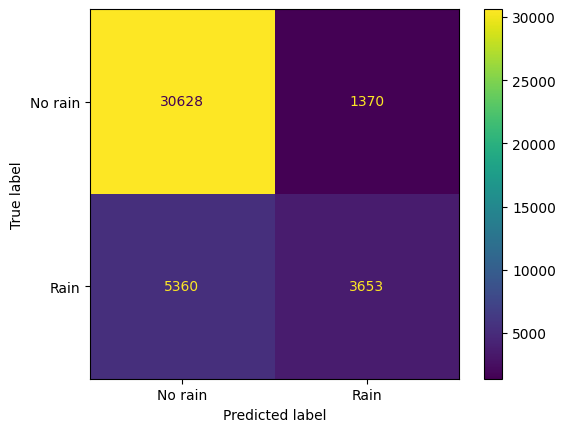

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

weather_df = pd.read_csv("weatherAUS.csv")

cols_to_keep = ["MinTemp", "MaxTemp", "Rainfall", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Temp9am", "Temp3pm", "RainToday", "RainTomorrow"]
weather_df = weather_df[cols_to_keep]

weather_df["RainToday"].replace({"No": 0, "Yes": 1}, inplace=True)
weather_df["RainTomorrow"].replace({"No": 0, "Yes": 1}, inplace=True)
weather_df = weather_df.dropna()

# splitting the data into train and test 
X = weather_df[["MinTemp", "MaxTemp", "Rainfall", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Temp9am", "Temp3pm", "RainToday"]]
y = weather_df[["RainTomorrow"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

# converting data into tensors to be used with pytorch
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

# this is the class for the neural network which inherits from the pytorch neural network module
# the hidden layers are wider than the input layer, and the output layer is one node that 
#   represents a value between 0 and 1 for the likelihood that it rains
class NN(nn.Module):
    def __init__(self, n):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n, n+1)
        self.layer2 = nn.Linear(n+1, n-2)
        self.layer3 = nn.Linear(n-2, 1)
    # this method accepts the x input and moves it through each layer of the network
    # relu and sigmoid are what make up the activation function that makes the data nonlinear
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return torch.sigmoid(self.layer3(x))

neural_net = NN(X_train.shape[1])

# BCEloss is a common loss function that I found while researching for this assignment, and it 
#   measures the distance between the prediction values and the real values. We want the value returned by
#   this function to be as close to 0 as possible. 
loss_func = nn.BCELoss()

# This is how we minimize the loss value. Adam is an optimizer I found while researching, it was easy to
#   implement and worked pretty well
# lr is the learning rate, which lowers the speed of the network but makes the parameters better
optimizer = optim.Adam(neural_net.parameters(), lr=0.001)

# this function converts the output from continuous to binary and calculates the accuracy
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

start_t = time.time()
# training the model
for epoch in range(1000):
    y_pred = neural_net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = loss_func(y_pred, y_train)
    if epoch % 200 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = neural_net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = loss_func(y_test, y_test_pred)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        print("Epoch", epoch)
        print("Training set accuracy:", round(train_acc.item(), 3), "Training set loss:", round(train_loss.item(), 3))
        print("Test set accuracy:", round(test_acc.item(), 3), "Test set loss:", round(test_loss.item(), 3))
    # the optimizer uses this to clear up the gradients and find better parameters    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

print("time elapsed for training the model:", time.time() - start_t, "seconds\n")

class_labels = ["No rain", "Rain"]
y_pred = neural_net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=class_labels))

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
display.plot()
plt.show()



